In [1]:
# Uncomment to set up in Colab
#!pip install --quiet torchtyping
#!rm -rf bayesian-flow-networks
#!git clone https://github.com/javidlakha/bayesian-flow-networks.git

#import sys
#sys.path.append('bayesian-flow-networks')

In [2]:
from typing import Hashable, Optional

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchtyping import TensorType
from tqdm.auto import tqdm

from bfn import DiscreteBFN

In [3]:
def dynamic_binarisation(
        img: TensorType['channels', 'height', 'width'],
    ) -> TensorType['channels', 'height', 'width']:
    p = torch.rand(1)
    return (img > p).long()

In [4]:
def get_data_loader(
    train: bool,
    batch_size: int,
) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(
        datasets.MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                dynamic_binarisation,
            ]),
        ),
        batch_size=batch_size,
        shuffle=train,
    )

In [5]:
training_loader = get_data_loader(train=True, batch_size=64)

100%|██████████| 9912422/9912422 [00:00<00:00, 501232247.63it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34939629.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 209034045.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4538001.14it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



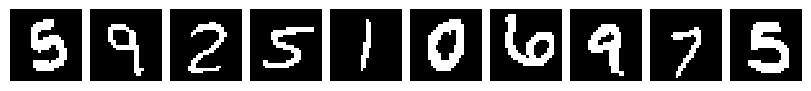

In [6]:
fig, ax = plt.subplots(1, 10, figsize=(8, 8),  layout='constrained')
img, label = next(iter(training_loader))
for i in range(10):
    ax[i].imshow(img[i][0], cmap='Greys_r', interpolation='nearest')
    ax[i].axis('off')
plt.show()

In [7]:
class Downsample(nn.Module):
    """Downsamples a H x W tensor into a H/2 x W/2 tensor"""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(
        self,
        x: TensorType['batch', 'channel', 'height', 'width'],
        **kwargs
    ) -> TensorType['batch', 'channel', 'height', 'width']:
        return self.conv(x)

In [8]:
class Upsample(nn.Module):
    """Upsamples a H x W tensor into a 2H x 2W tensor"""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(
        self,
        x: TensorType['batch', 'channel', 'height', 'width'],
        **kwargs
    ) -> TensorType['batch', 'channel', 'height', 'width']:
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        x = self.conv(x)
        return x

In [9]:
class Connection(nn.Module):
    """An identity function used to signal residual connections"""

    def __init__(self, identifier: Hashable) -> None:
        super().__init__()
        self.identifier = identifier

    def forward(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        return x

InputConnection = Connection
OutputConnection = Connection

In [10]:
class ResnetBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        time_channels: int,
        dropout: float,
        groups: int = 32,
    ) -> None:
        """A ResNet block containing two convolutions"""
        super().__init__()

        self.time_projection = nn.Linear(time_channels, out_channels)

        self.norm0 = nn.GroupNorm(groups, in_channels, eps=1e-6)
        self.conv0 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.norm1 = nn.GroupNorm(groups, out_channels, eps=1e-6)
        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        self.act = nn.SiLU()

        if in_channels != out_channels:
            self.conv_shortcut = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        else:
            self.conv_shortcut = None

    def forward(
        self,
        x: TensorType['batch', 'channel', 'height', 'width'],
        t: TensorType['batch', 'embedding'],
        **kwargs,
    ) -> TensorType['batch', 'channel', 'height', 'width']:
        t = self.time_projection(self.act(t))[:, :, None, None]

        h = self.norm0(x).type(x.dtype)
        h = self.act(h)
        h = self.conv0(h)
        h = self.norm1(h + t).type(x.dtype)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv1(h)

        if self.conv_shortcut:
            x = self.conv_shortcut(x)

        return x + h

In [11]:
class GatedFeedForward(nn.Module):
    def __init__(
        self,
        dimension: int,
        inner_dimension: int,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.gated_projection = nn.Linear(dimension, 2 * inner_dimension)
        self.dropout = nn.Dropout(dropout)
        self.output_projection = nn.Linear(inner_dimension, dimension)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, gate = self.gated_projection(x).chunk(2, dim=-1)
        x = x * F.gelu(gate)
        x = self.dropout(x)
        x = self.output_projection(x)

        return x

In [12]:
class SpatialTransformer(nn.Module):
    def __init__(
        self,
        channels: int,
        n_heads: int,
        d_head: int,
        d_context: Optional[int] = None,
        dropout: float = 0.0,
    ):
        """
        A 2D Transformer block consisting of:
          - an input convolution
          - an attention layer
          - a gated feedforward layer
          - an output convolution
        """
        super().__init__()

        self.group_norm = torch.nn.GroupNorm(32, channels, eps=1e-6)
        self.input_projection = nn.Conv2d(
            channels,
            n_heads*d_head,
            kernel_size=1,
            stride=1,
            padding=0,
        )

        self.layer_norm0 = nn.LayerNorm(n_heads*d_head)
        self.attention0 = nn.MultiheadAttention(
            n_heads*d_head,
            n_heads,
            dropout,
            batch_first=True,
        )

        self.layer_norm1 = nn.LayerNorm(n_heads*d_head)
        self.attention1 = nn.MultiheadAttention(
            n_heads*d_head,
            n_heads,
            dropout,
            kdim=d_context,
            vdim=d_context,
            batch_first=True,
        ) if d_context else None

        self.layer_norm2 = nn.LayerNorm(n_heads*d_head)
        self.gated_feed_forward = GatedFeedForward(
            n_heads*d_head,
            4*n_heads*d_head,
            dropout=dropout,
        )

        self.output_projection = nn.Conv2d(
            n_heads*d_head,
            channels,
            kernel_size=1,
            stride=1,
            padding=0,
        )

    def forward(
        self,
        x: TensorType['batch', 'channel', 'height', 'width'],
        context: Optional[TensorType['batch', 'embedding']] = None,
        **kwargs,
    ) -> TensorType['batch', 'channel', 'height', 'width']:
        h = self.group_norm(x)
        h = self.input_projection(h)

        batch, channel, height, width = x.shape
        h = h.permute(0, 2, 3, 1).reshape(batch, height * width, channel)

        n = self.layer_norm0(h)
        h = self.attention0(n, n, n)[0] + h

        n = self.layer_norm1(h)
        if self.attention1 and isinstance(context, torch.Tensor):
            c = context[:,:,None].permute(0, 2, 1)
            h = self.attention1(n, c, c)[0] + h

        n = self.layer_norm2(h)
        h = self.gated_feed_forward(n) + h

        h = h.reshape(batch, height, width, channel).permute(0, 3, 1, 2)
        h = self.output_projection(h)

        return h + x

In [13]:
class TimeEmbedding(nn.Module):
    def __init__(self, in_channels: int, embedding_dim: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim

        self.lin0 = nn.Linear(in_channels, embedding_dim)
        self.act = nn.SiLU()
        self.lin1 = nn.Linear(embedding_dim, embedding_dim)

    def forward(
        self,
        timesteps: TensorType['batch'],
    ) -> TensorType['batch', 'embedding']:
        exponent = torch.arange(
            start=0,
            end=self.embedding_dim//2,
            dtype=torch.float32,
            device=timesteps.device,
        ) / (self.embedding_dim//2)
        t = timesteps[:, None].float() * torch.exp(exponent)[None, :]
        t = torch.cat([torch.sin(t), torch.cos(t)], dim=-1)

        t = self.lin0(t)
        t = self.act(t)
        t = self.lin1(t)
        return t

In [14]:
class UNet(nn.Module):
    def __init__(
        self,
        sequence_len: int,
        vocab_size: int,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()

        # Preprocessing
        self.in_conv = nn.Conv2d(2, 128, kernel_size=3, padding=(1, 1))
        self.time_embedding = TimeEmbedding(128, 128)
        self.context_embedding = nn.Embedding(10, 128)

        # Downsampling
        self.downsampling_blocks = nn.ModuleList([
            OutputConnection('0'),

            ResnetBlock(128, 128, 128, dropout),
            SpatialTransformer(128, 8, 16, 128, dropout),
            OutputConnection('1'),

            ResnetBlock(128, 128, 128, dropout),
            SpatialTransformer(128, 8, 16, 128, dropout),
            OutputConnection('2'),

            Downsample(128, 128),
            OutputConnection('3'),

            ResnetBlock(128, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),
            OutputConnection('4'),

            ResnetBlock(256, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),
            OutputConnection('5'),

            Downsample(256, 256),
            OutputConnection('6'),

            ResnetBlock(256, 256, 128, dropout),
            OutputConnection('7'),

            ResnetBlock(256, 256, 128, dropout),
            OutputConnection('8'),
        ])

        self.intermediate_blocks = nn.ModuleList([
            ResnetBlock(256, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),
            ResnetBlock(256, 256, 128, dropout),
        ])

        # Upsampling
        self.upsampling_blocks = nn.ModuleList([
            InputConnection('8'),
            ResnetBlock(512, 256, 128, dropout),

            InputConnection('7'),
            ResnetBlock(512, 256, 128, dropout),

            InputConnection('6'),
            ResnetBlock(512, 256, 128, dropout),
            Upsample(256, 256),

            InputConnection('5'),
            ResnetBlock(512, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),

            InputConnection('4'),
            ResnetBlock(512, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),

            InputConnection('3'),
            ResnetBlock(384, 256, 128, dropout),
            SpatialTransformer(256, 8, 32, 128, dropout),
            Upsample(256, 256),

            InputConnection('2'),
            ResnetBlock(384, 128, 128, dropout),
            SpatialTransformer(128, 8, 16, 128, dropout),

            InputConnection('1'),
            ResnetBlock(256, 128, 128, dropout),
            SpatialTransformer(128, 8, 16, 128, dropout),

            InputConnection('0'),
            ResnetBlock(256, 128, 128, dropout),
            SpatialTransformer(128, 8, 16, 128, dropout),
        ])

        # Postprocessing
        self.norm = nn.GroupNorm(num_channels=128, num_groups=32, eps=1e-05)
        self.act = nn.SiLU()
        self.out_conv = nn.Conv2d(128, 2, 3, padding=1)

    def forward(
        self,
        x: TensorType['batch', 'sequence', 'vocab'],
        t: TensorType['batch'],
        context: Optional[TensorType['batch', 'context']] = None,
    ) -> TensorType['batch', 'sequence', 'vocab']:
        batch_size, sequence_len, vocab_size = x.shape

        # Reshape to (batch_size, vocab_size+1, height, width)
        x = x.view(batch_size, vocab_size, 28, 28)

        # Preprocessing
        x = self.in_conv(x)
        t = self.time_embedding(t)
        if isinstance(context, torch.Tensor):
            c = self.context_embedding(context)
        else:
            c = None

        # Downsampling
        residual_samples = {}
        for block in self.downsampling_blocks:
            if isinstance(block, OutputConnection):
                residual_samples[block.identifier] = x
            else:
                x = block(x, t=t, context=c)

        for intermediate_block in self.intermediate_blocks:
            x = intermediate_block(x, t=t, context=c)

        # Upsampling
        for block in self.upsampling_blocks:
            if isinstance(block, InputConnection):
                r = residual_samples.pop(block.identifier)
                x = torch.cat([x, r], dim=1)
            else:
                x = block(x, t=t, context=c)

        # Postprocessing
        x = self.norm(x)
        x = self.act(x)
        x = self.out_conv(x)

        # Reshape back to (batch_size, sequence_len, vocab_size)
        x = x.view(batch_size, sequence_len, vocab_size)

        return x

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sequence_len = 28*28
vocab_size = 2
epochs = 100

In [16]:
unet = UNet(sequence_len, vocab_size, dropout=0.5)
bfn = DiscreteBFN(sequence_len, vocab_size, unet)
bfn.to(device);

In [17]:
optimiser = optim.AdamW(bfn.parameters(), betas=(0.9, 0.98), lr=1e-3)

In [18]:
num_params = sum(p.numel() for p in bfn.parameters() if p.requires_grad)
print(f'Trainable parameters: {num_params:,}')

Trainable parameters: 32,652,930


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/100


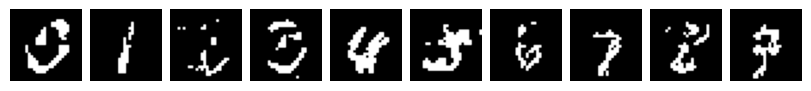

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/100


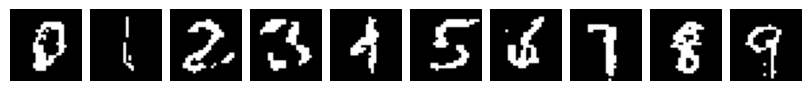

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/100


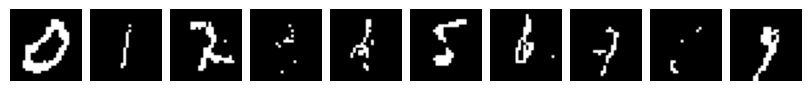

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/100


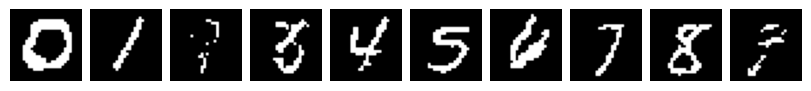

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/100


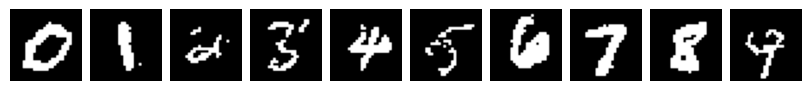

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/100


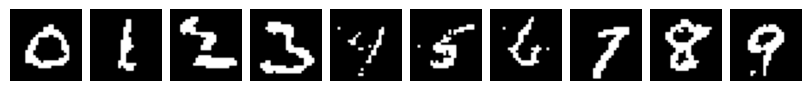

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/100


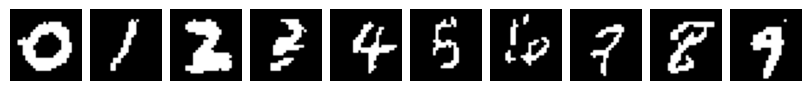

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/100


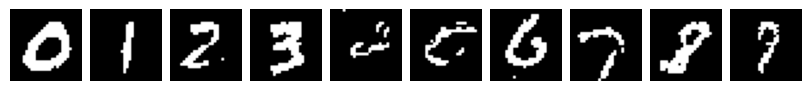

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/100


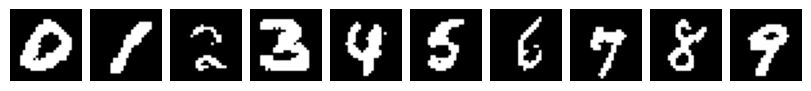

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/100


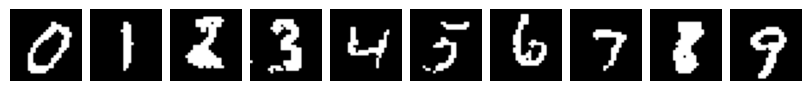

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/100


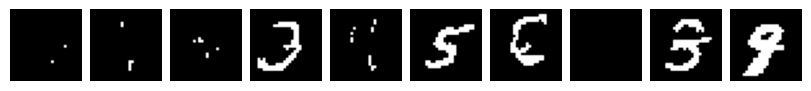

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/100


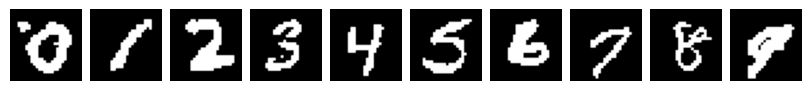

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/100


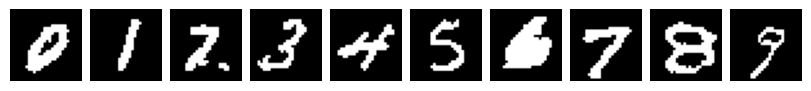

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/100


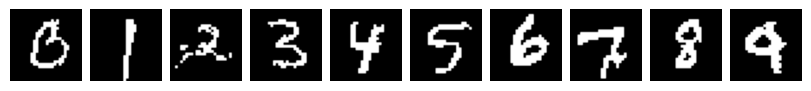

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/100


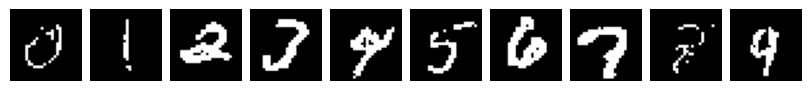

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/100


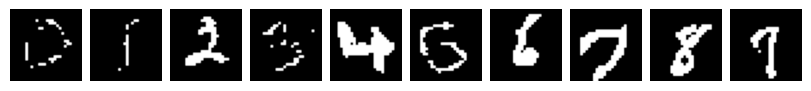

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/100


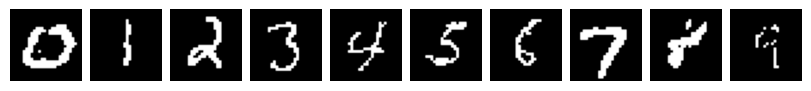

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/100


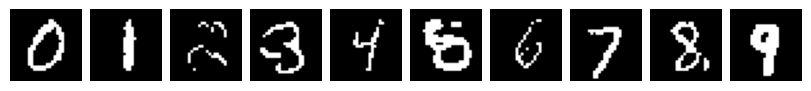

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/100


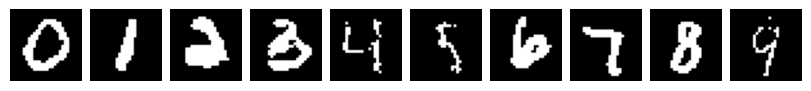

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/100


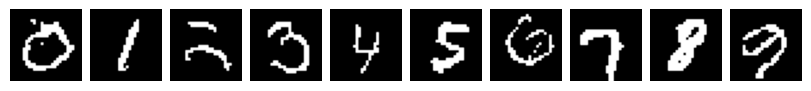

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/100


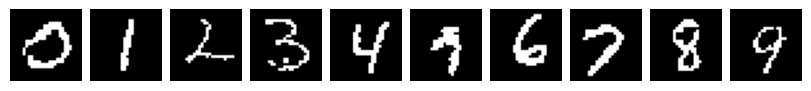

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22/100


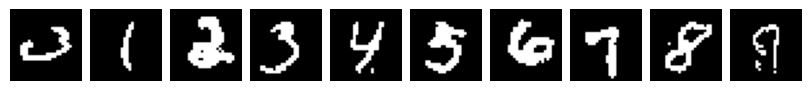

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23/100


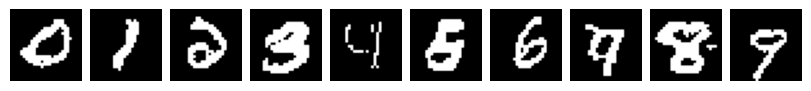

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24/100


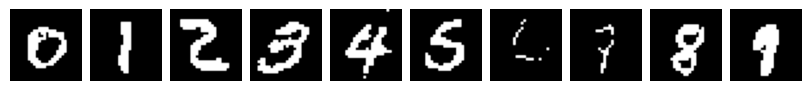

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25/100


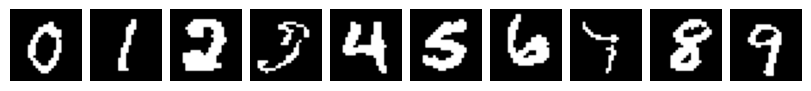

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26/100


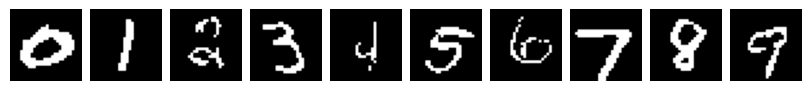

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27/100


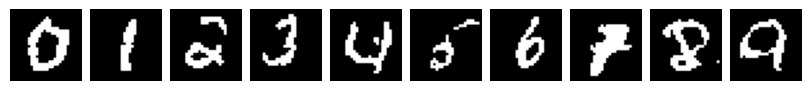

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28/100


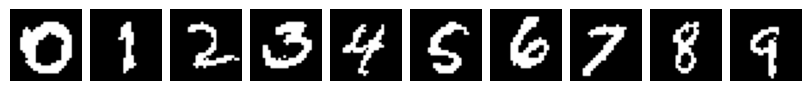

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29/100


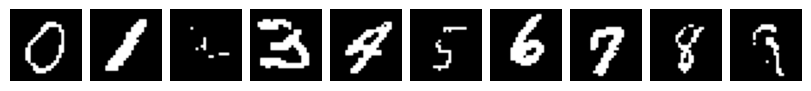

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30/100


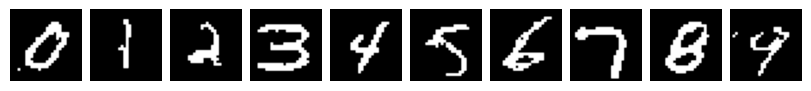

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31/100


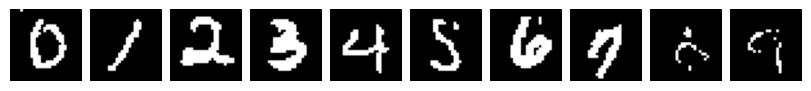

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32/100


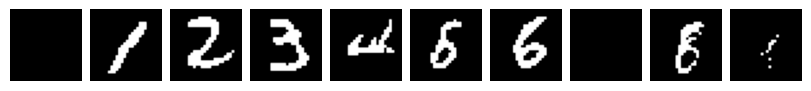

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33/100


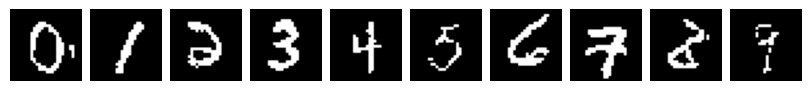

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34/100


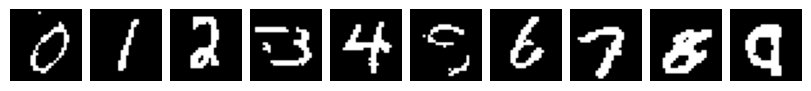

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35/100


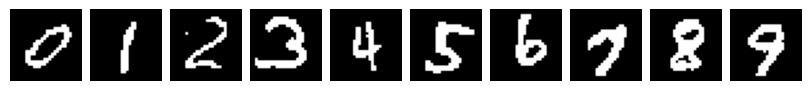

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36/100


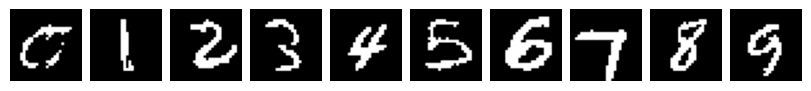

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37/100


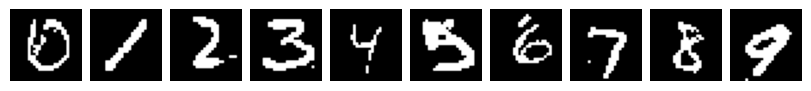

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38/100


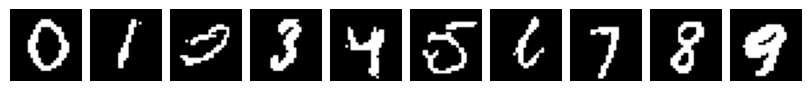

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39/100


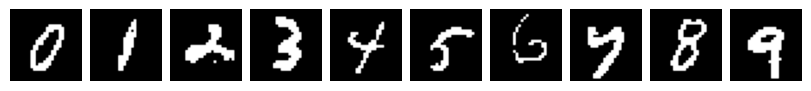

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40/100


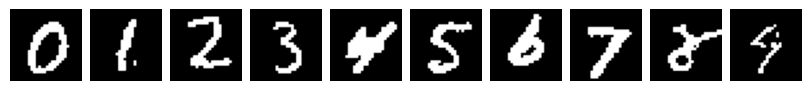

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41/100


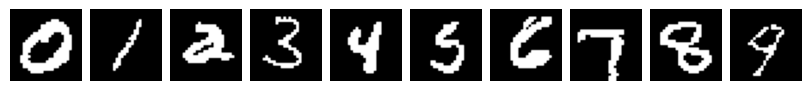

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42/100


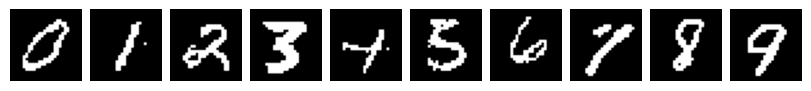

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43/100


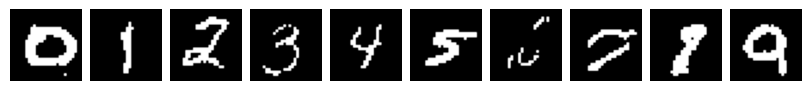

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44/100


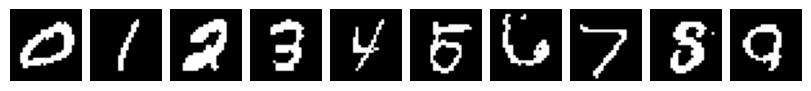

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45/100


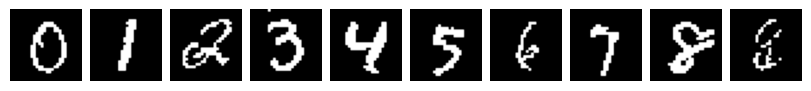

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46/100


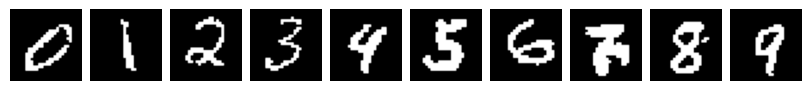

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47/100


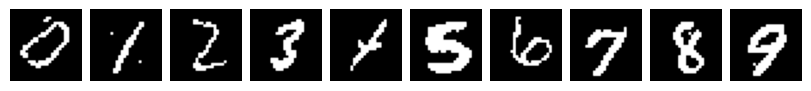

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48/100


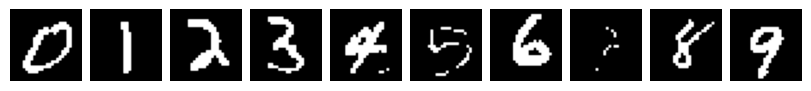

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49/100


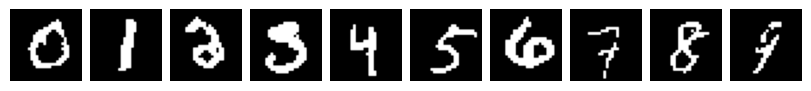

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50/100


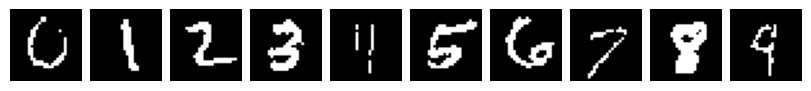

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 51/100


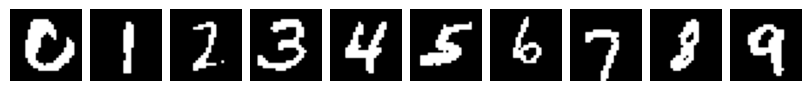

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 52/100


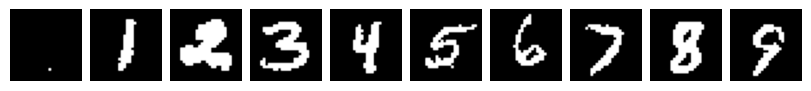

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53/100


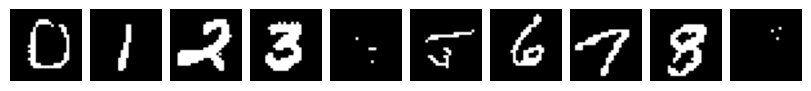

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 54/100


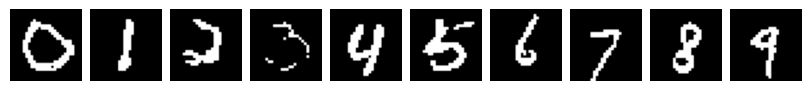

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 55/100


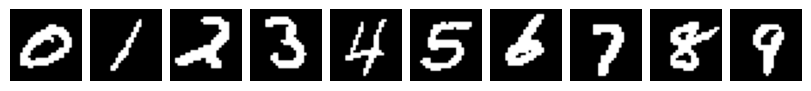

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 56/100


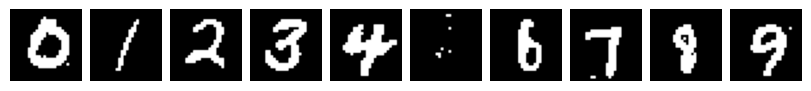

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 57/100


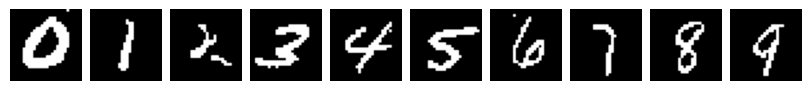

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58/100


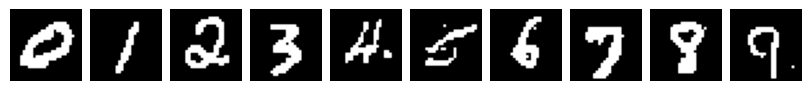

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 59/100


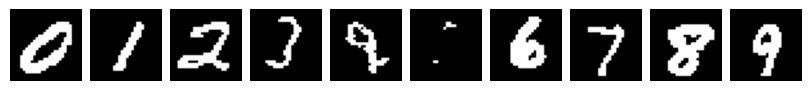

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 60/100


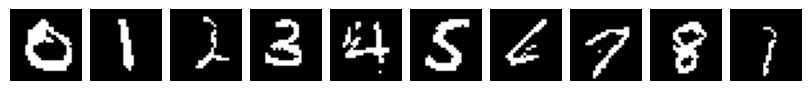

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 61/100


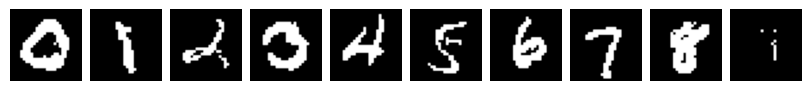

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 62/100


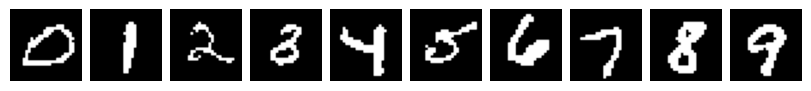

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63/100


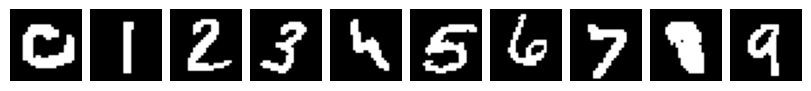

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 64/100


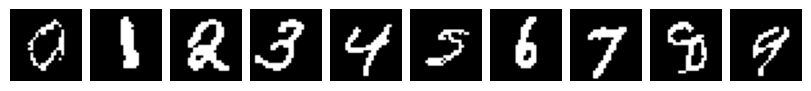

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 65/100


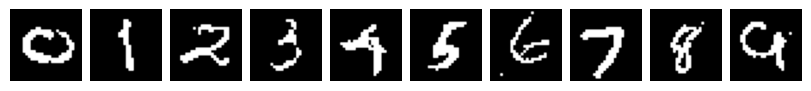

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 66/100


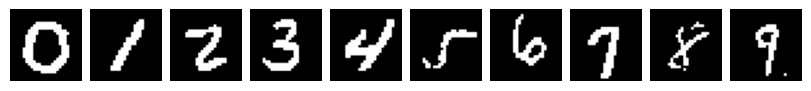

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 67/100


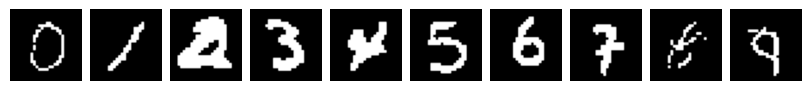

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 68/100


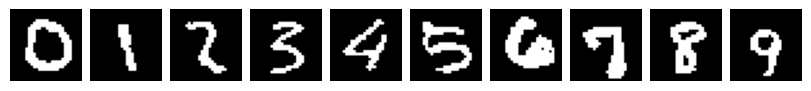

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69/100


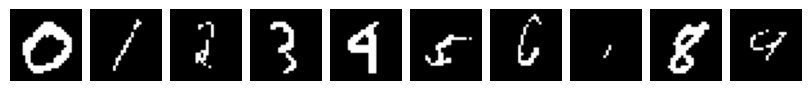

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 70/100


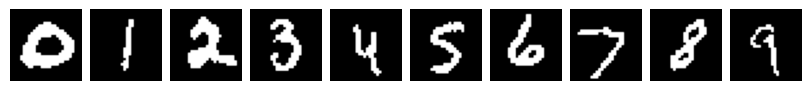

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 71/100


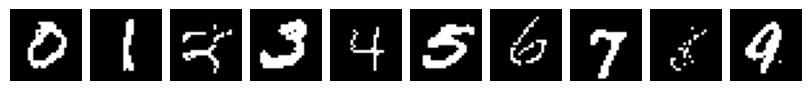

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 72/100


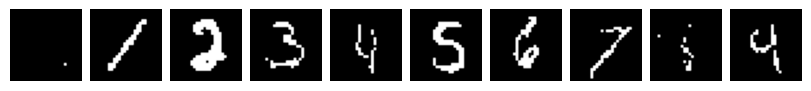

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 73/100


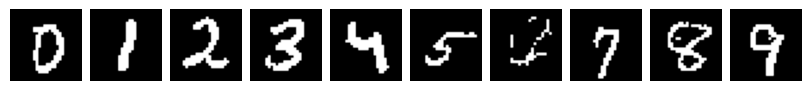

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74/100


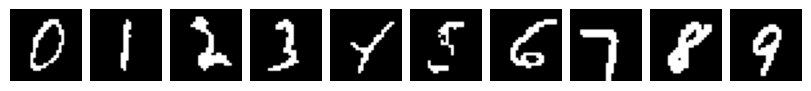

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 75/100


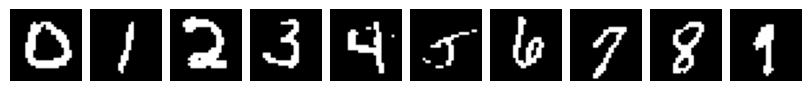

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 76/100


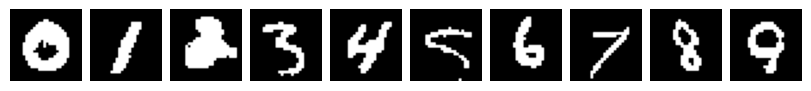

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 77/100


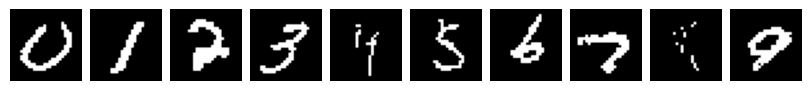

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 78/100


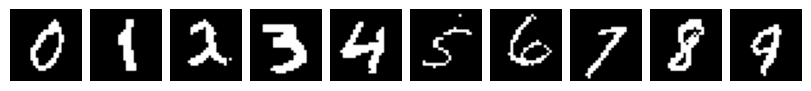

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79/100


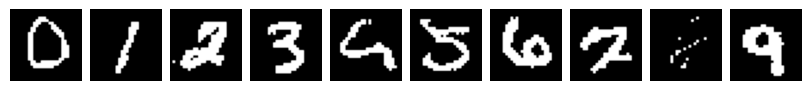

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 80/100


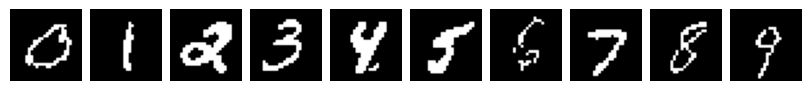

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 81/100


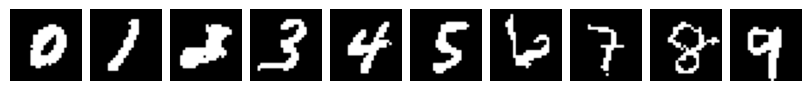

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 82/100


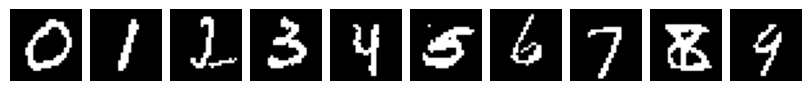

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 83/100


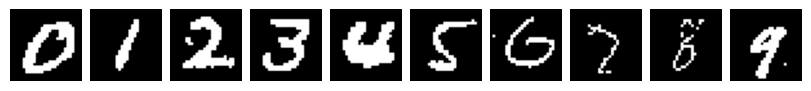

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 84/100


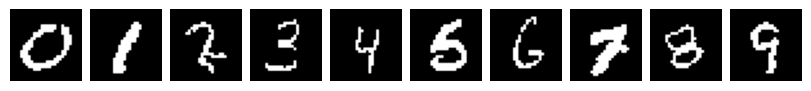

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85/100


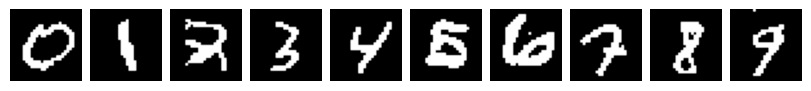

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 86/100


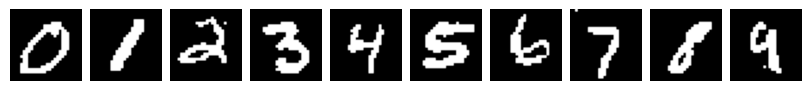

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 87/100


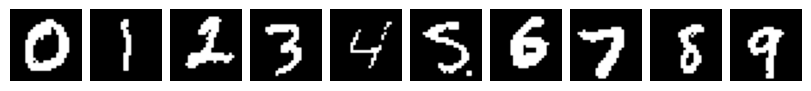

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 88/100


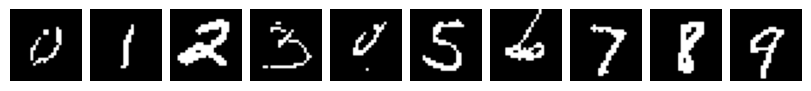

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 89/100


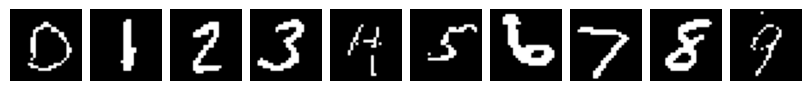

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 90/100


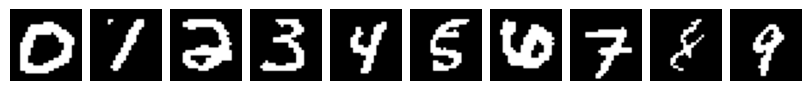

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 91/100


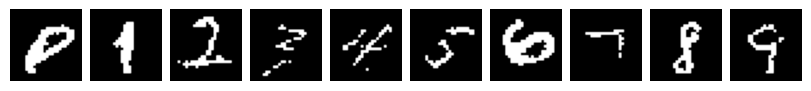

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 92/100


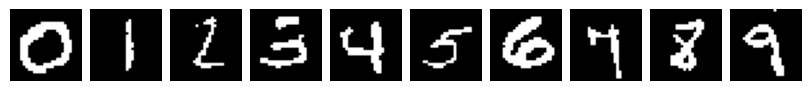

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 93/100


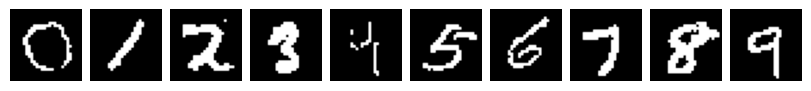

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 94/100


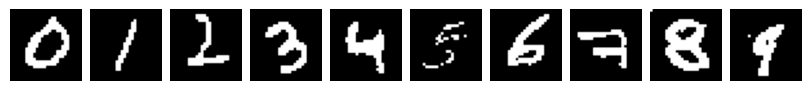

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 95/100


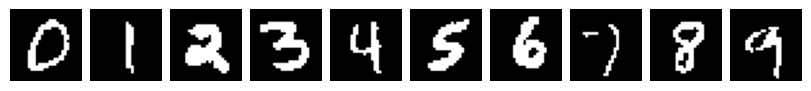

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 96/100


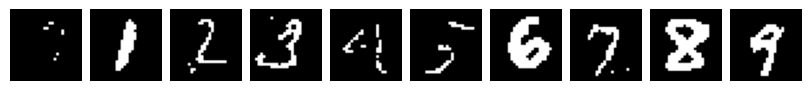

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 97/100


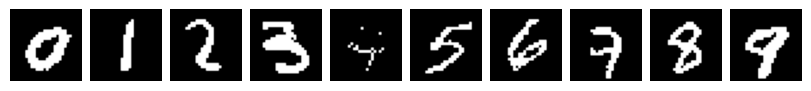

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 98/100


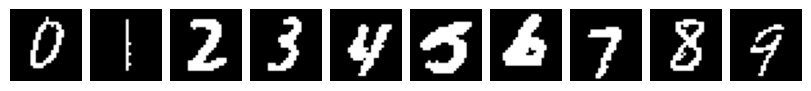

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 99/100


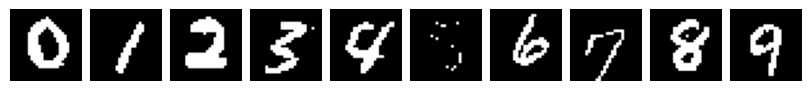

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 100/100


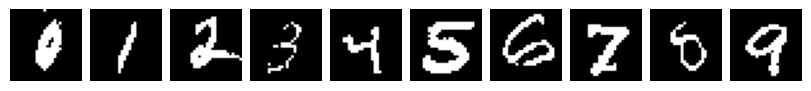

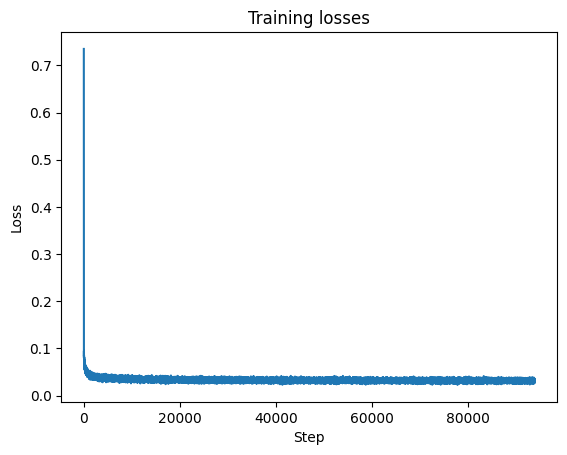

In [19]:
losses = []
for epoch in tqdm(range(epochs)):
    for batch, label in tqdm(training_loader, leave=False):
        batch = batch.view(-1, 28*28).to(device)
        label = label.to(device)
        optimiser.zero_grad()
        loss = bfn.continuous_time_loss(batch, label)
        loss.backward()
        optimiser.step()
        losses.append(loss.detach().item())

    X = bfn.generate(
        batch_size=10,
        steps=1024,
        device=device,
        context=torch.Tensor(range(10)).long().to(device),
    ).cpu().numpy()

    print(f'Epoch {epoch+1}/{epochs}')
    fig, ax = plt.subplots(1, 10, figsize=(8, 8),  layout='constrained')
    for i in range(10):
        ax[i].imshow(X[i].reshape(28,28), cmap='Greys_r')
        ax[i].axis('off')
    plt.show()

plt.title('Training losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()